# Illustrate committor active learning with AMS on the MB potential

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Imports for AMS and muller brown potential

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.AMSSimulation import AMSOverdampedLangevin

Import for committor learning

In [4]:
from committor.neural_net_models import CommittorOneDecoder
from committor.train_committor import TainCommittorOverdampedOneDecoder

Define potential and neural net for committor approximation and the corresponding training object 

In [5]:
pot = MullerBrown()
committor = CommittorOneDecoder([2, 20, 20, 1], [1, 10, 10, 2], 0, pot)

Define temperature via $\beta = \left( k_\mathrm{B} T \right)^{-1}$, time step size and AMS simulation object 

In [6]:
beta = 0.05
dt = 0.0001
AMS_on_MB = AMSOverdampedLangevin(pot, xi=None, beta=beta, forward=True, dt=dt, threshold=10**(-8))

Run dynamics to sample intitial conditions in reactant and product metastable state

In [7]:
n_conditions = 20
n_rep = 20
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(True)
print(n_steps_b + n_steps_f)

1022


Define the first training dataset for the committor function based only on short trajectories for initial conditions

In [8]:
dataset = np.concatenate((ini_traj_f["x_traj"][:-1, :], ini_traj_f["gauss_traj"][1:, :], ini_traj_f["x_traj"][1:, :]), axis=1)
dataset = np.append(dataset, np.concatenate((ini_traj_b["x_traj"][:-1, :], ini_traj_b["gauss_traj"][1:, :], ini_traj_b["x_traj"][1:, :]), axis=1), axis=0)
dataset = {"any_distrib" : dataset, "beta" : beta, "dt" : dt}
print(dataset["any_distrib"].shape)

(1020, 6)


   Define the committor training object, and prepare training

In [9]:
committor_training = TainCommittorOverdampedOneDecoder(committor, pot, dataset)
committor_training.train_test_split(train_size=5 * 10**2)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.005)
loss_params = {}
loss_params["ito_loss_weight"] = 1.0
loss_params["pen_points_weight"] = 1.0 * 10**0
loss_params["n_wait"] = 50

committor_training.set_loss_weight(loss_params)
batch_size = 100
max_epochs = 5000

squared_grad_boltz_weight value not provided, set to default value of:  0.0
mse_boltz_weight value not provided, set to default value of:  0.0
mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0


Train the committor model 

In [10]:
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 945 epochs.



Plot results

/tmp/ipykernel_51891/1923860637.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_51891/1923860637.py:23: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

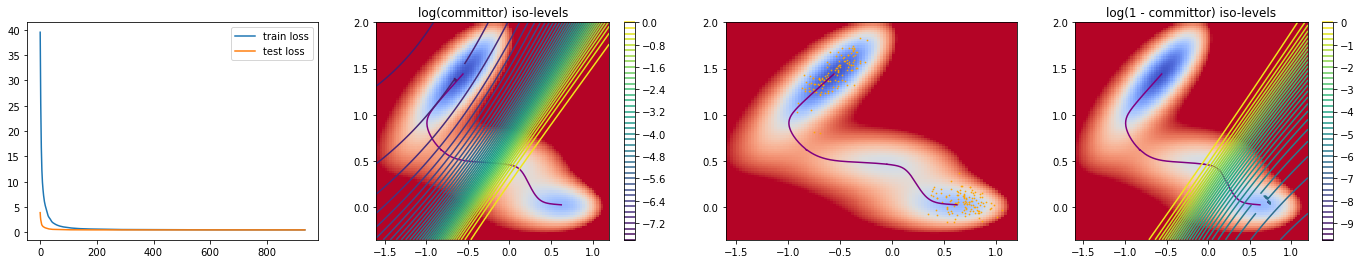

In [11]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][10:], label='train loss')
ax0.plot(loss_dict["test_loss"][10:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Run AMS forward

In [12]:
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(True)

In [13]:
print(p_f)
print(p_b)

0.0017390335276272382
0.0032440149346570314


Add the new sampled trajectories to the dataset


In [14]:
for i in range(len(replicas_b)):
    dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((replicas_b[i]["x_traj"][:-1, :], replicas_b[i]["gauss_traj"][1:, :], replicas_b[i]["x_traj"][1:, :]), axis=1), axis=0)
for i in range(len(replicas_f)):
    dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((replicas_f[i]["x_traj"][:-1, :], replicas_f[i]["gauss_traj"][1:, :], replicas_f[i]["x_traj"][1:, :]), axis=1), axis=0)
print(dataset["any_distrib"].shape)

(44966, 6)


Re-set the training dataset and train again 

In [15]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size=4 * 10**4)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.005)
batch_size = 1000
max_epochs = 5000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 123 epochs.



Plot the results 

/tmp/ipykernel_51891/1923860637.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_51891/1923860637.py:23: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

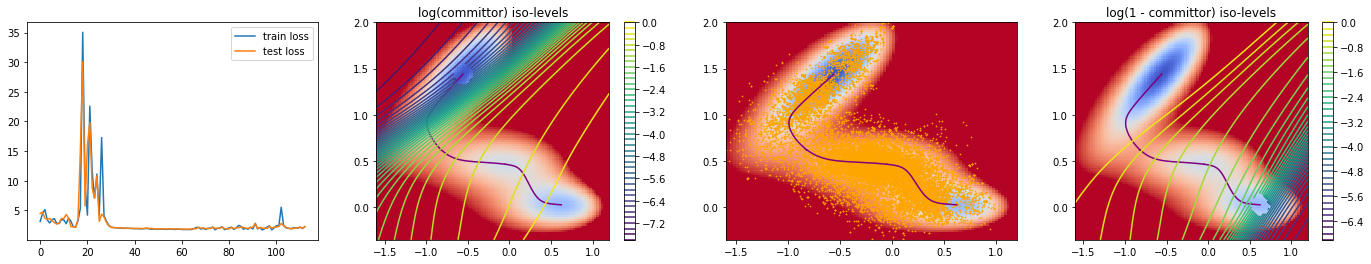

In [16]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][10:], label='train loss')
ax0.plot(loss_dict["test_loss"][10:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")

Sample some new initial conditions 

In [17]:
n_conditions = 1000
n_rep = 1000
k_min = 1
ini_traj_f, ini_conds_f, _, n_steps_f = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(False)
ini_traj_b, ini_conds_b, _, n_steps_b = AMS_on_MB.sample_initial_conditions(n_conditions=n_conditions, save_gauss=True)
AMS_on_MB.set_forward(True)
print(n_steps_b + n_steps_f)

69377


Add to the dataset

In [18]:
dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((ini_traj_f["x_traj"][:-1, :], ini_traj_f["gauss_traj"][1:, :], ini_traj_f["x_traj"][1:, :]), axis=1), axis=0)
dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((ini_traj_b["x_traj"][:-1, :], ini_traj_b["gauss_traj"][1:, :], ini_traj_b["x_traj"][1:, :]), axis=1), axis=0)
print(dataset["any_distrib"].shape)

(114341, 6)


Run AMS again 

In [19]:
AMS_on_MB.set_xi(committor_training.committor_model.xi_forward)
p_f, z_kills_f, replicas_f, total_md_steps_f = AMS_on_MB.ams_run(ini_conds_f, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(False)
AMS_on_MB.set_xi(committor_training.committor_model.xi_backward)
p_b, z_kills_b, replicas_b, total_md_steps_b = AMS_on_MB.ams_run(ini_conds_b, n_rep, k_min, return_all=True, save_gauss=True)
AMS_on_MB.set_forward(True)

In [20]:
print(p_f)
print(p_b)

0.002550919739902665
0.013268399809191967


Add sampled trajectories data to dataset 

In [21]:
for i in range(len(replicas_b)):
    dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((replicas_b[i]["x_traj"][:-1, :], replicas_b[i]["gauss_traj"][1:, :], replicas_b[i]["x_traj"][1:, :]), axis=1), axis=0)
for i in range(len(replicas_f)):
    dataset["any_distrib"] = np.append(dataset["any_distrib"], np.concatenate((replicas_f[i]["x_traj"][:-1, :], replicas_f[i]["gauss_traj"][1:, :], replicas_f[i]["x_traj"][1:, :]), axis=1), axis=0)
print(dataset["any_distrib"].shape)

(2247106, 6)


Re-train

In [22]:
committor_training.set_dataset(dataset)
committor_training.train_test_split(train_size=2 * 10**5)
committor_training.split_training_dataset_K_folds(2)
committor_training.set_train_val_data(0)
committor_training.set_optimizer('Adam', 0.005)
batch_size = 10000
max_epochs = 5000
loss_dict = committor_training.train(batch_size, max_epochs)

training ends after 137 epochs.



/tmp/ipykernel_51891/1678055877.py:11: RuntimeWarning: divide by zero encountered in log
  contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
/tmp/ipykernel_51891/1678055877.py:23: RuntimeWarning: divide by zero encountered in log
  contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')


Text(0.5, 1.0, 'log(1 - committor) iso-levels')

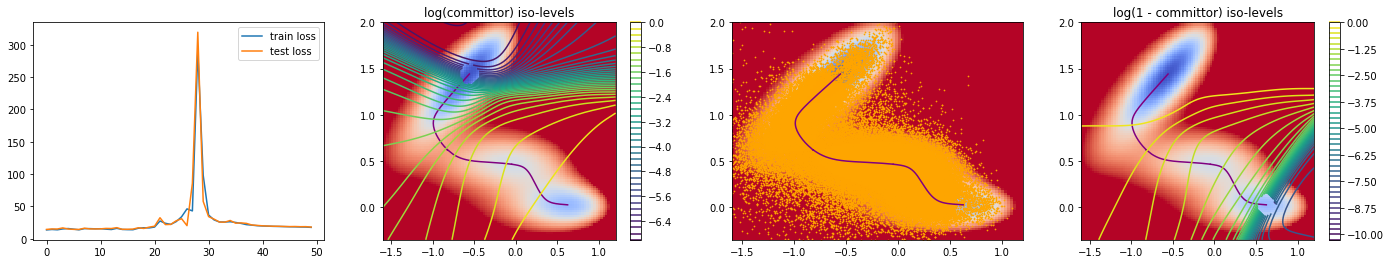

In [27]:
xi_on_grid = committor_training.committor_model.xi_forward(pot.x2d).reshape([100, 100])
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(24, 4)) 
# loss function evolution 
ax0.plot(loss_dict["train_loss"][-50:], label='train loss')
ax0.plot(loss_dict["test_loss"][-50:], label='test loss')
ax0.legend()
# log committor plot 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour1 = ax1.contour(pot.x_plot, pot.y_plot, np.log(xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour1, ax=ax1) 
ax1.set_title("log(committor) iso-levels")
# dataset distribution 
pot.plot_potential_heat_map(ax2)
ax2.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax2.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax2.scatter(committor_training.train_data[:, 0], committor_training.train_data[:, 1], color='orange', s=0.5)
# log 1- committor plot  
pot.plot_potential_heat_map(ax3)
ax3.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax3.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
contour3 = ax3.contour(pot.x_plot, pot.y_plot, np.log(1-xi_on_grid), 40, cmap='viridis')
fig.colorbar(contour3, ax=ax3) 
ax3.set_title("log(1 - committor) iso-levels")